In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")




/home/demetra/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [3]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [4]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [5]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


RIDGE

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.292175	0.00198566 	-0.289374  	-0.295508  
1  	100   	-0.29391 	0.00146338 	-0.290172  	-0.295599  
2  	100   	-0.294824	0.00076729 	-0.291775  	-0.295599  
3  	100   	-0.294964	0.00102094 	-0.290249  	-0.295599  
4  	100   	-0.295112	0.000877878	-0.292022  	-0.296306  
5  	100   	-0.295107	0.00116786 	-0.289384  	-0.296306  
6  	100   	-0.295323	0.000567416	-0.292814  	-0.296306  
7  	100   	-0.295138	0.00108573 	-0.289696  	-0.296306  
8  	100   	-0.295214	0.000980209	-0.290882  	-0.296291  
9  	100   	-0.295211	0.000617558	-0.292852  	-0.295599  
10 	100   	-0.294864	0.000977278	-0.291879  	-0.295599  
11 	100   	-0.295044	0.000823763	-0.292676  	-0.295567  
12 	100   	-0.295278	0.000686942	-0.291491  	-0.295568  
13 	100   	-0.295252	0.000569761	-0.29306   	-0.295572  
14 	100   	-0.295205	0.000883547	-0.29104   	-0.295572  
15 	100   	-0.295105	0.000815663	-0.292142  	-0.295572  
16 	100   	-0.295224	0.00051786

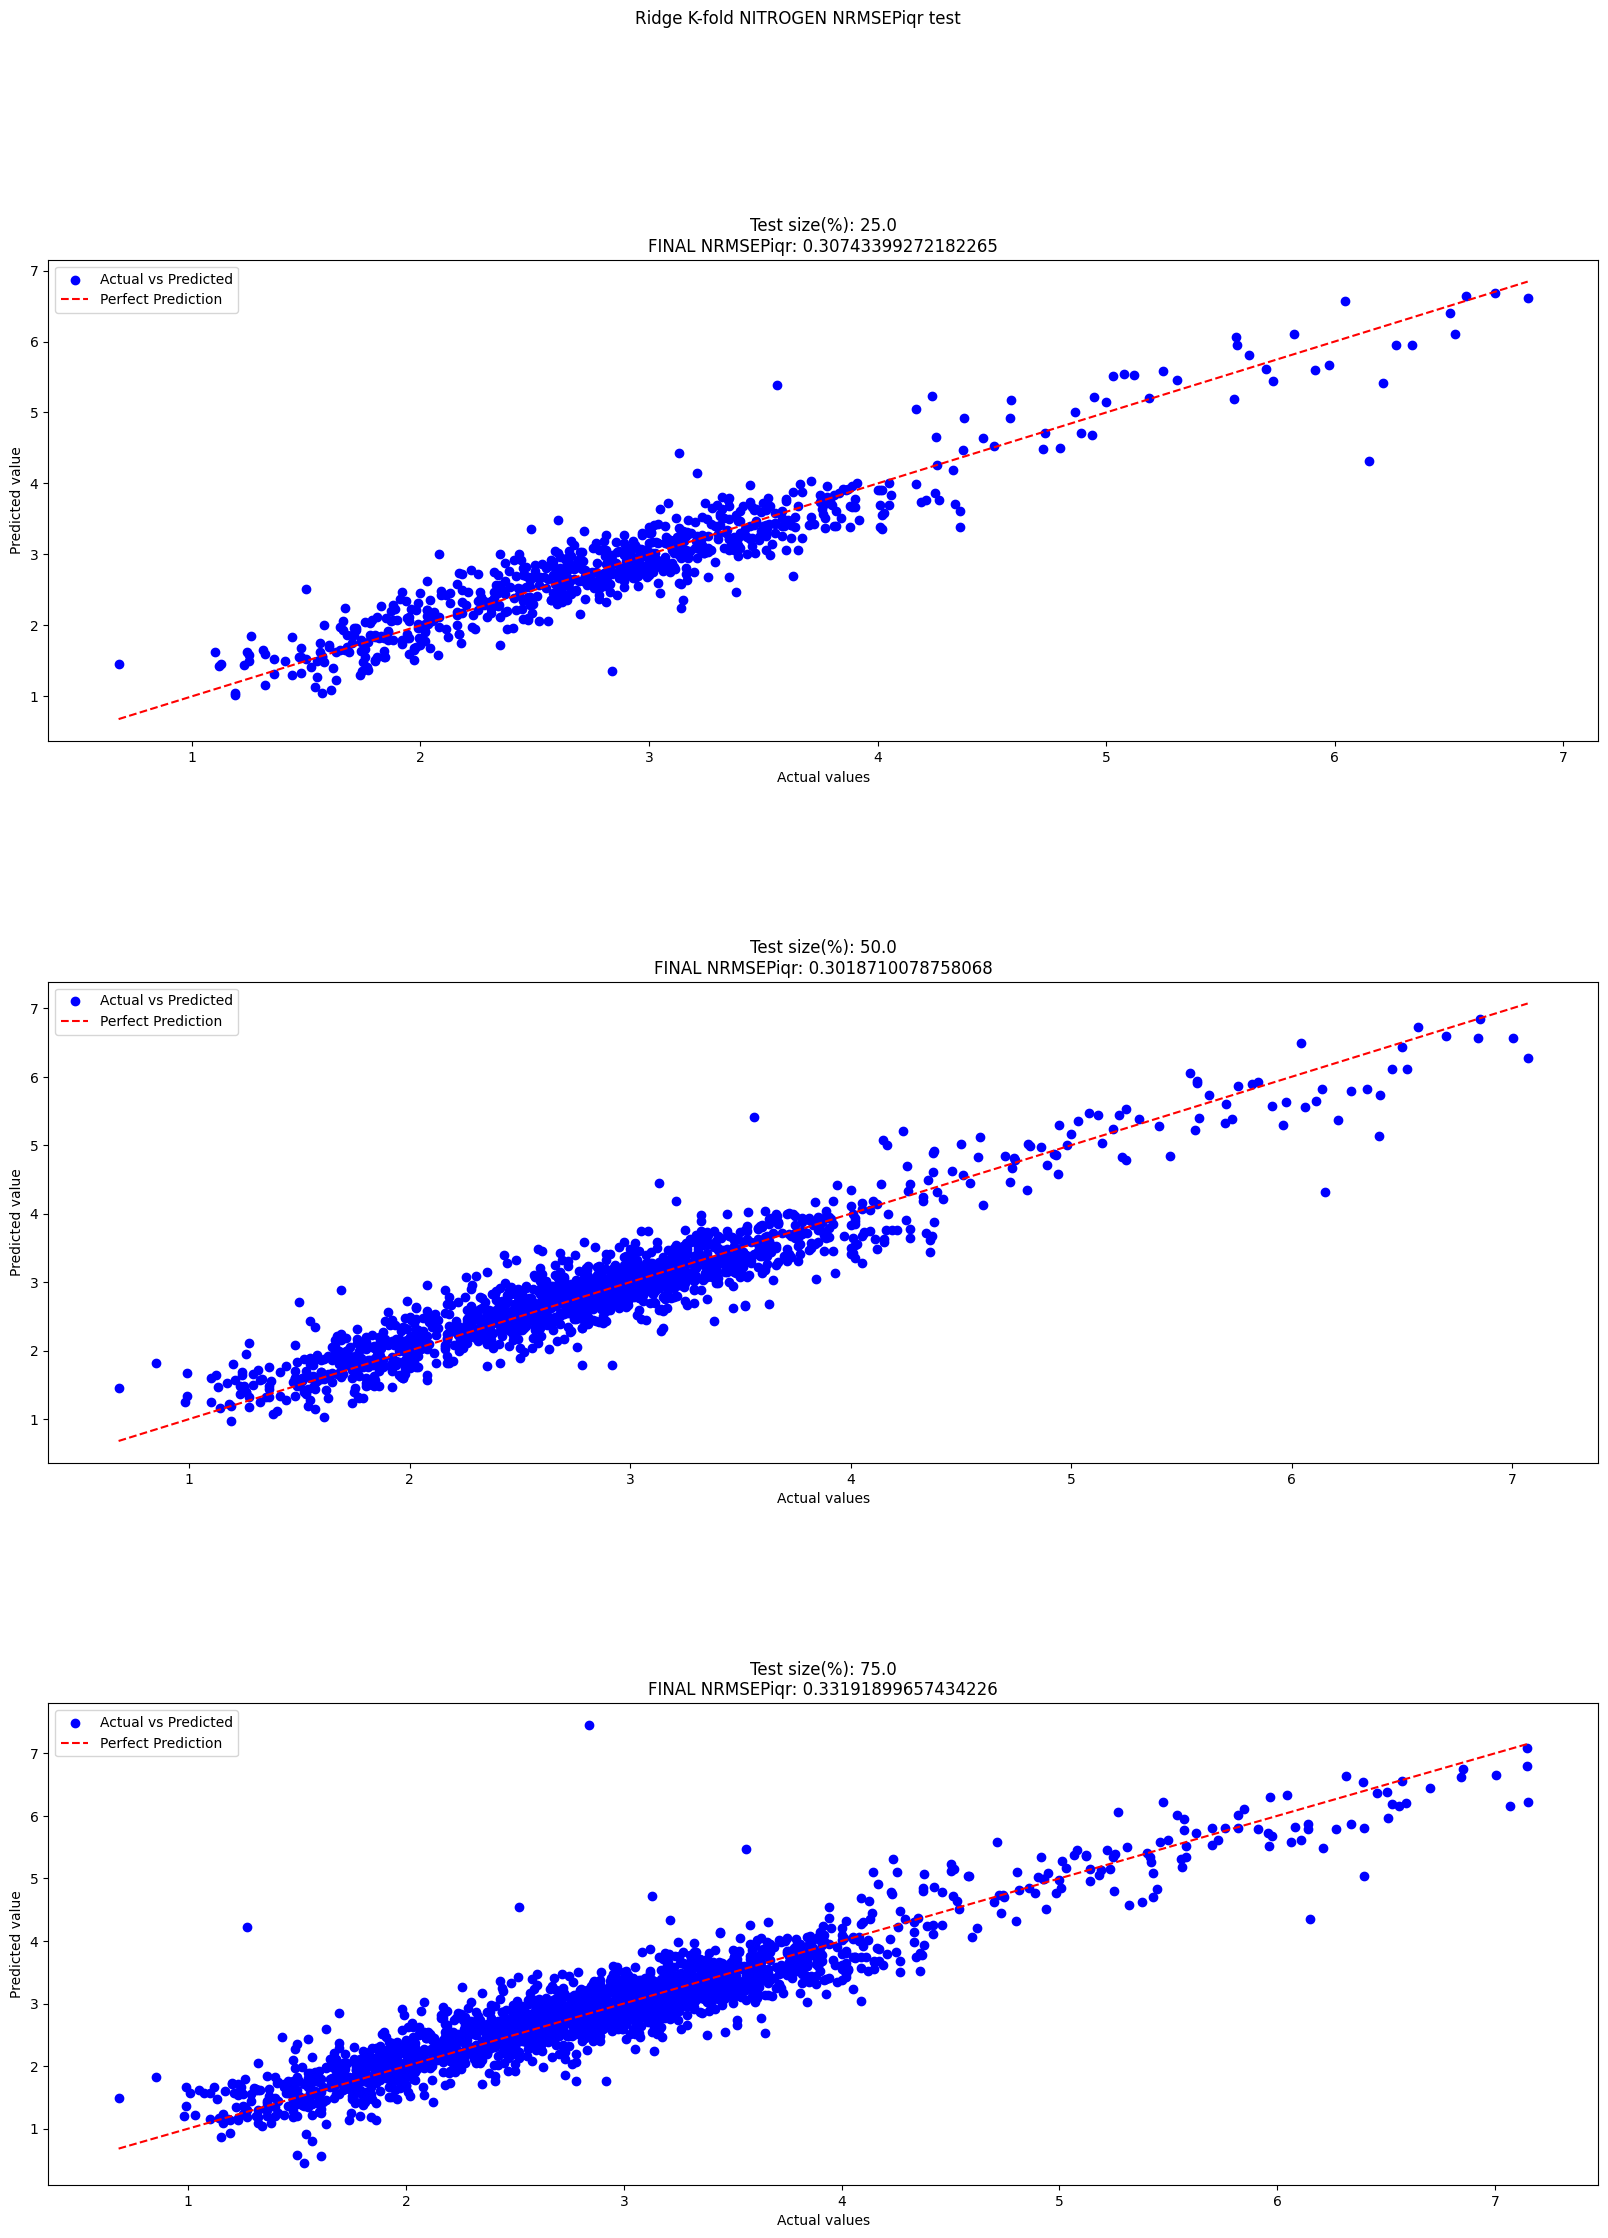

In [5]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge K-fold NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'ridge__alpha': Continuous(1/100000,0.01)}
    ridge_pipeline = make_pipeline(StandardScaler(), Ridge())
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=ridge_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best vaue of alpha: ", str(evolved_estimator.best_params_["ridge__alpha"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_ridge_cl = best_model.predict(X_test)

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_ridge_cl),float(evolved_estimator.best_params_["ridge__alpha"])])

    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_ridge_cl))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_ridge_cl, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_ridge_cl) ))
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","alpha"]
print(tabulate(results, headers,  tablefmt="double_outline"))

LASSO

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.511374	0.0348982  	-0.45185   	-0.552702  
1  	100   	-0.538294	0.0180398  	-0.482527  	-0.552732  
2  	100   	-0.548237	0.00689047 	-0.524448  	-0.552762  
3  	100   	-0.549116	0.00535286 	-0.523066  	-0.552732  
4  	100   	-0.550211	0.00417487 	-0.533035  	-0.55277   
5  	100   	-0.550364	0.00989286 	-0.482855  	-0.55277   
6  	100   	-0.551453	0.00442414 	-0.52676   	-0.552945  
7  	100   	-0.549539	0.00879757 	-0.507989  	-0.552945  
8  	100   	-0.54764 	0.0146449  	-0.470201  	-0.552945  
9  	100   	-0.550074	0.00625629 	-0.517934  	-0.552945  
10 	100   	-0.549812	0.0072383  	-0.514327  	-0.552945  
11 	100   	-0.549653	0.0102947  	-0.491479  	-0.552945  
12 	100   	-0.55029 	0.00737008 	-0.512039  	-0.552945  
13 	100   	-0.549288	0.010695   	-0.492246  	-0.552945  
14 	100   	-0.550687	0.00699106 	-0.518003  	-0.552945  
15 	100   	-0.550775	0.00598915 	-0.518003  	-0.552945  
16 	100   	-0.551517	0.00478365

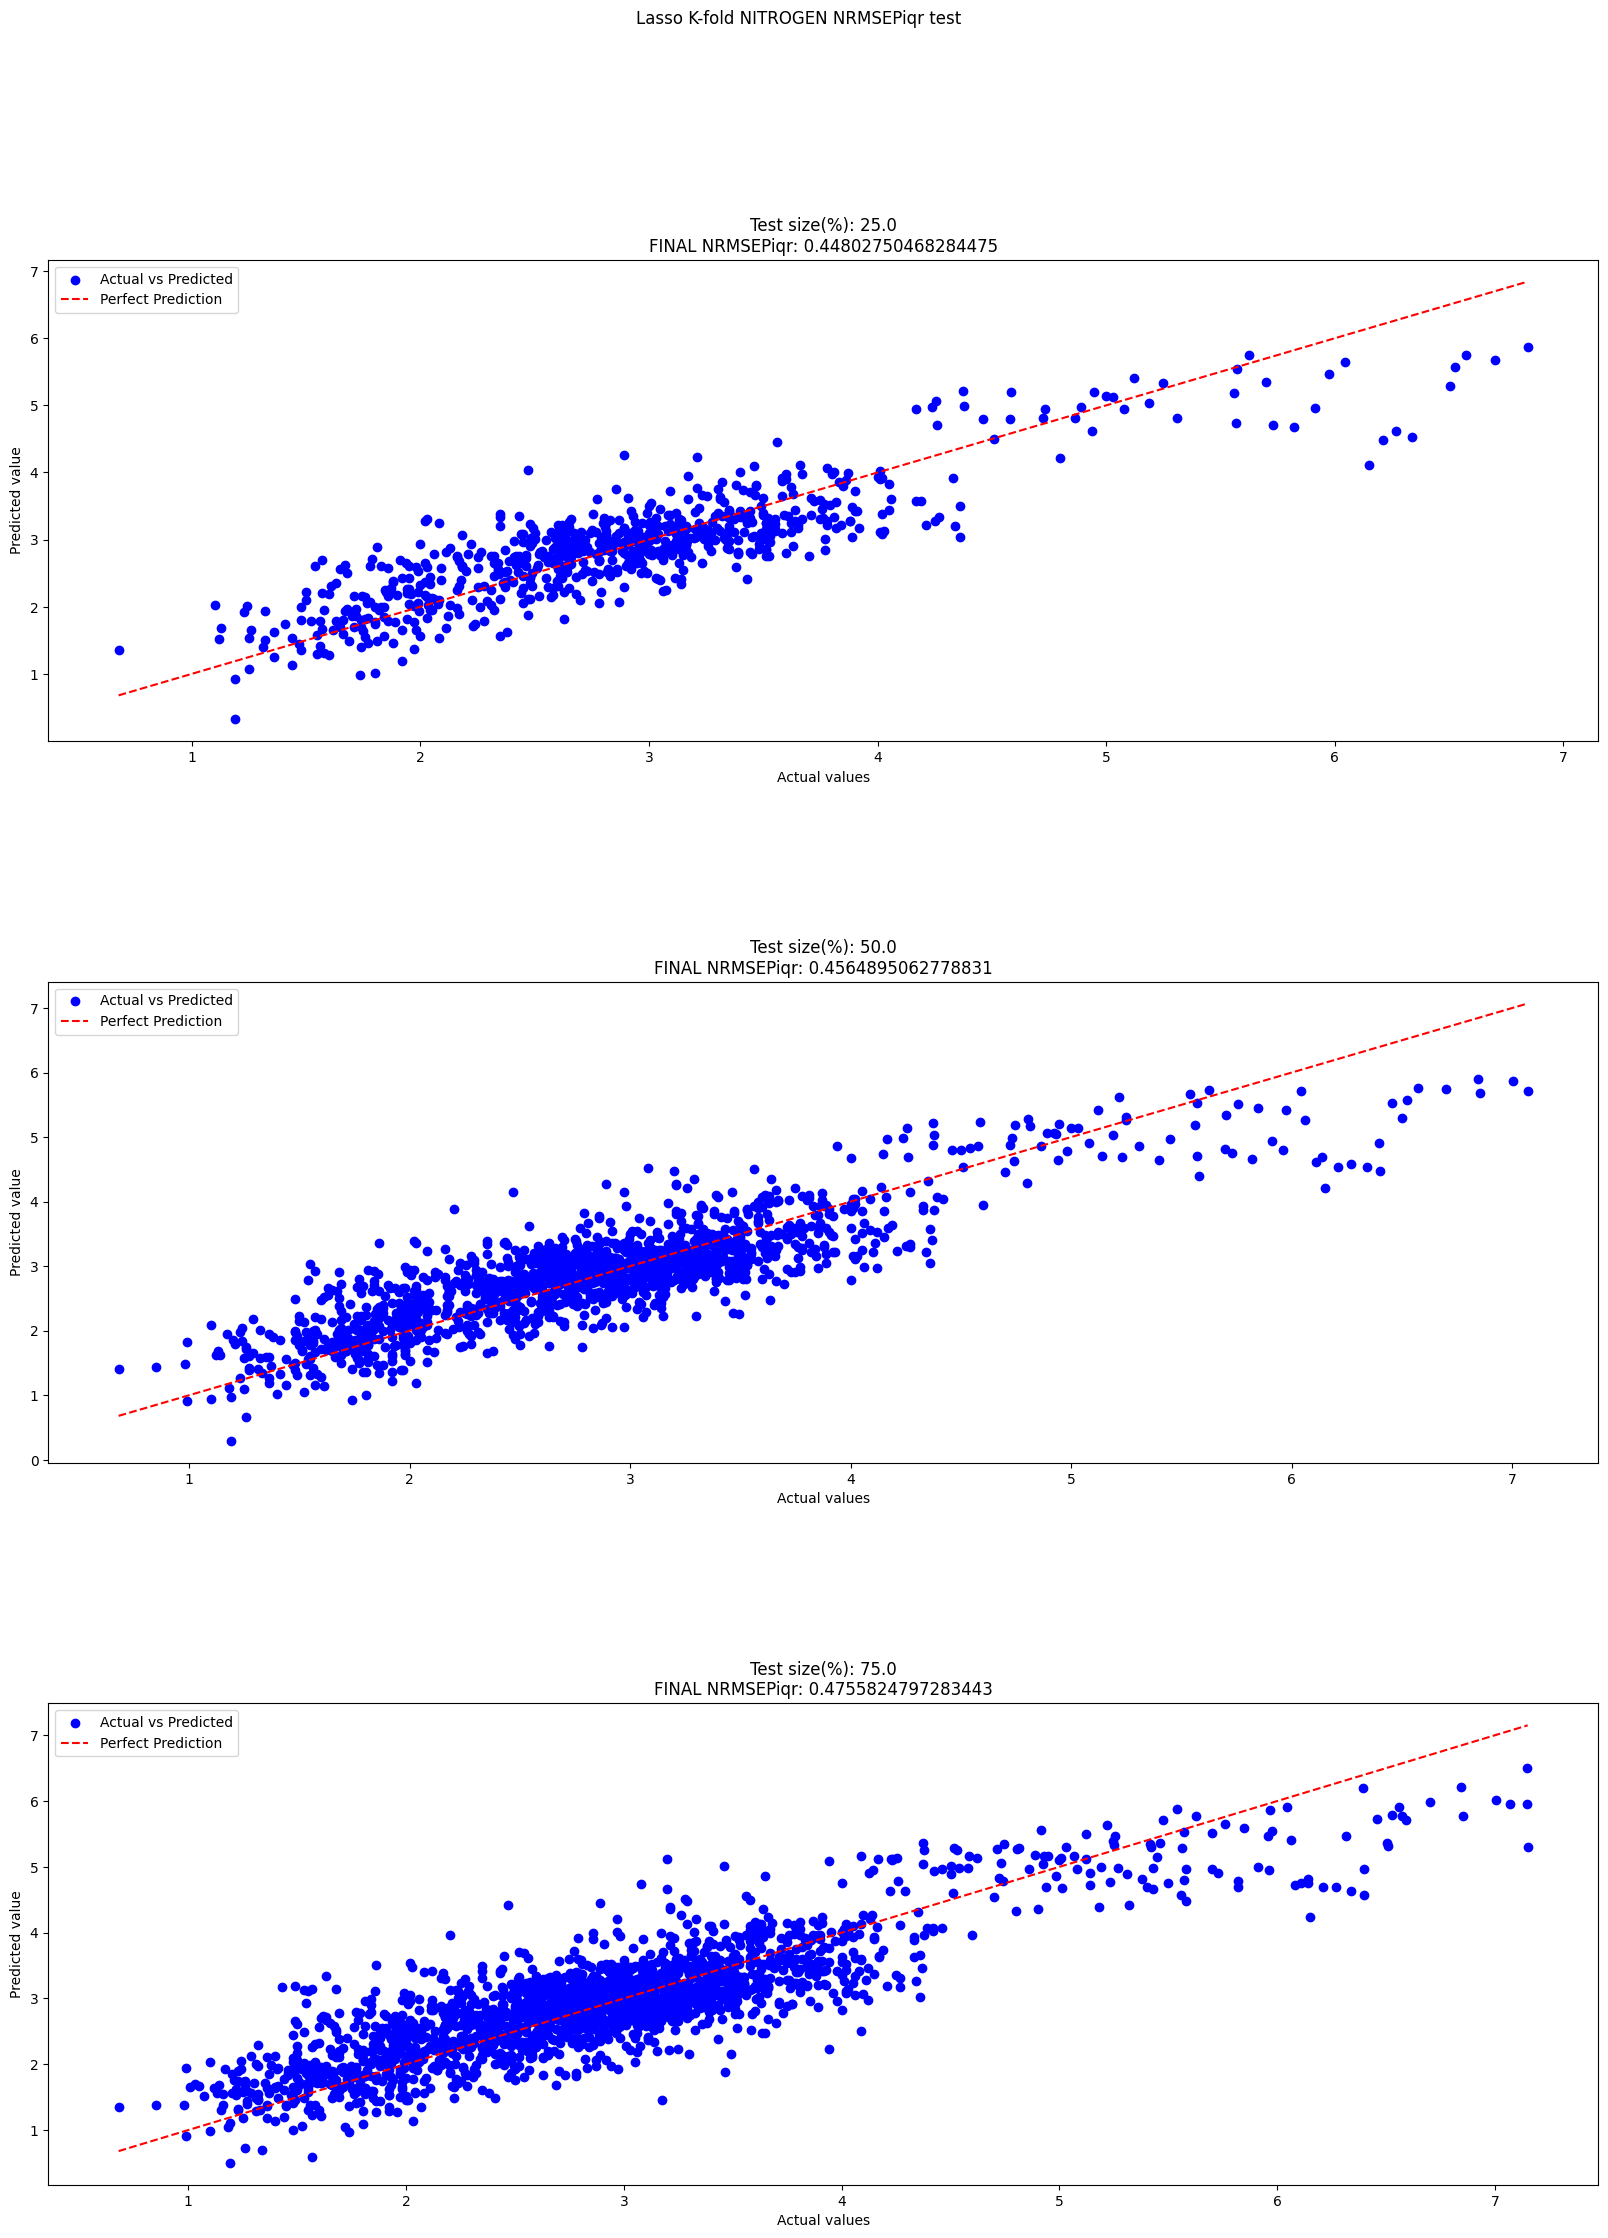

In [6]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


np.random.seed(42)


ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso K-fold NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'lasso__alpha': Continuous(1/100000,0.01)}
    lasso_pipeline = make_pipeline(StandardScaler(),  Lasso())
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=lasso_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best vaue of alpha: ", str(evolved_estimator.best_params_["lasso__alpha"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_lasso_cd = best_model.predict(X_test)


    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_lasso_cd),float(evolved_estimator.best_params_["lasso__alpha"])])



    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_lasso_cd))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_lasso_cd, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_lasso_cd) ))
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","alpha"]
print(tabulate(results, headers,  tablefmt="double_outline"))



Elastic Net

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	50    	-0.4842	0.0335626  	-0.436523  	-0.551427  
1  	100   	-0.509673	0.0284986  	-0.444683  	-0.552054  
2  	100   	-0.529742	0.0189366  	-0.477714  	-0.552054  
3  	100   	-0.539722	0.0109929  	-0.497564  	-0.551213  
4  	100   	-0.546042	0.00481649 	-0.525307  	-0.551507  
5  	100   	-0.548093	0.00423735 	-0.532336  	-0.551836  
6  	100   	-0.548478	0.00473364 	-0.532073  	-0.551836  
7  	100   	-0.548714	0.00553684 	-0.523362  	-0.552538  
8  	100   	-0.54866 	0.00632066 	-0.52149   	-0.552125  
9  	100   	-0.550173	0.00400624 	-0.52848   	-0.552125  
10 	100   	-0.549059	0.00968705 	-0.490788  	-0.552535  
11 	100   	-0.550176	0.00340794 	-0.537836  	-0.552535  
12 	100   	-0.550514	0.00309097 	-0.536631  	-0.552535  
13 	100   	-0.550463	0.00324077 	-0.537895  	-0.552535  
14 	100   	-0.548473	0.0105058  	-0.483013  	-0.552535  
15 	100   	-0.550772	0.00330137 	-0.531471  	-0.552535  
16 	100   	-0.549659	0.00696054 	-0

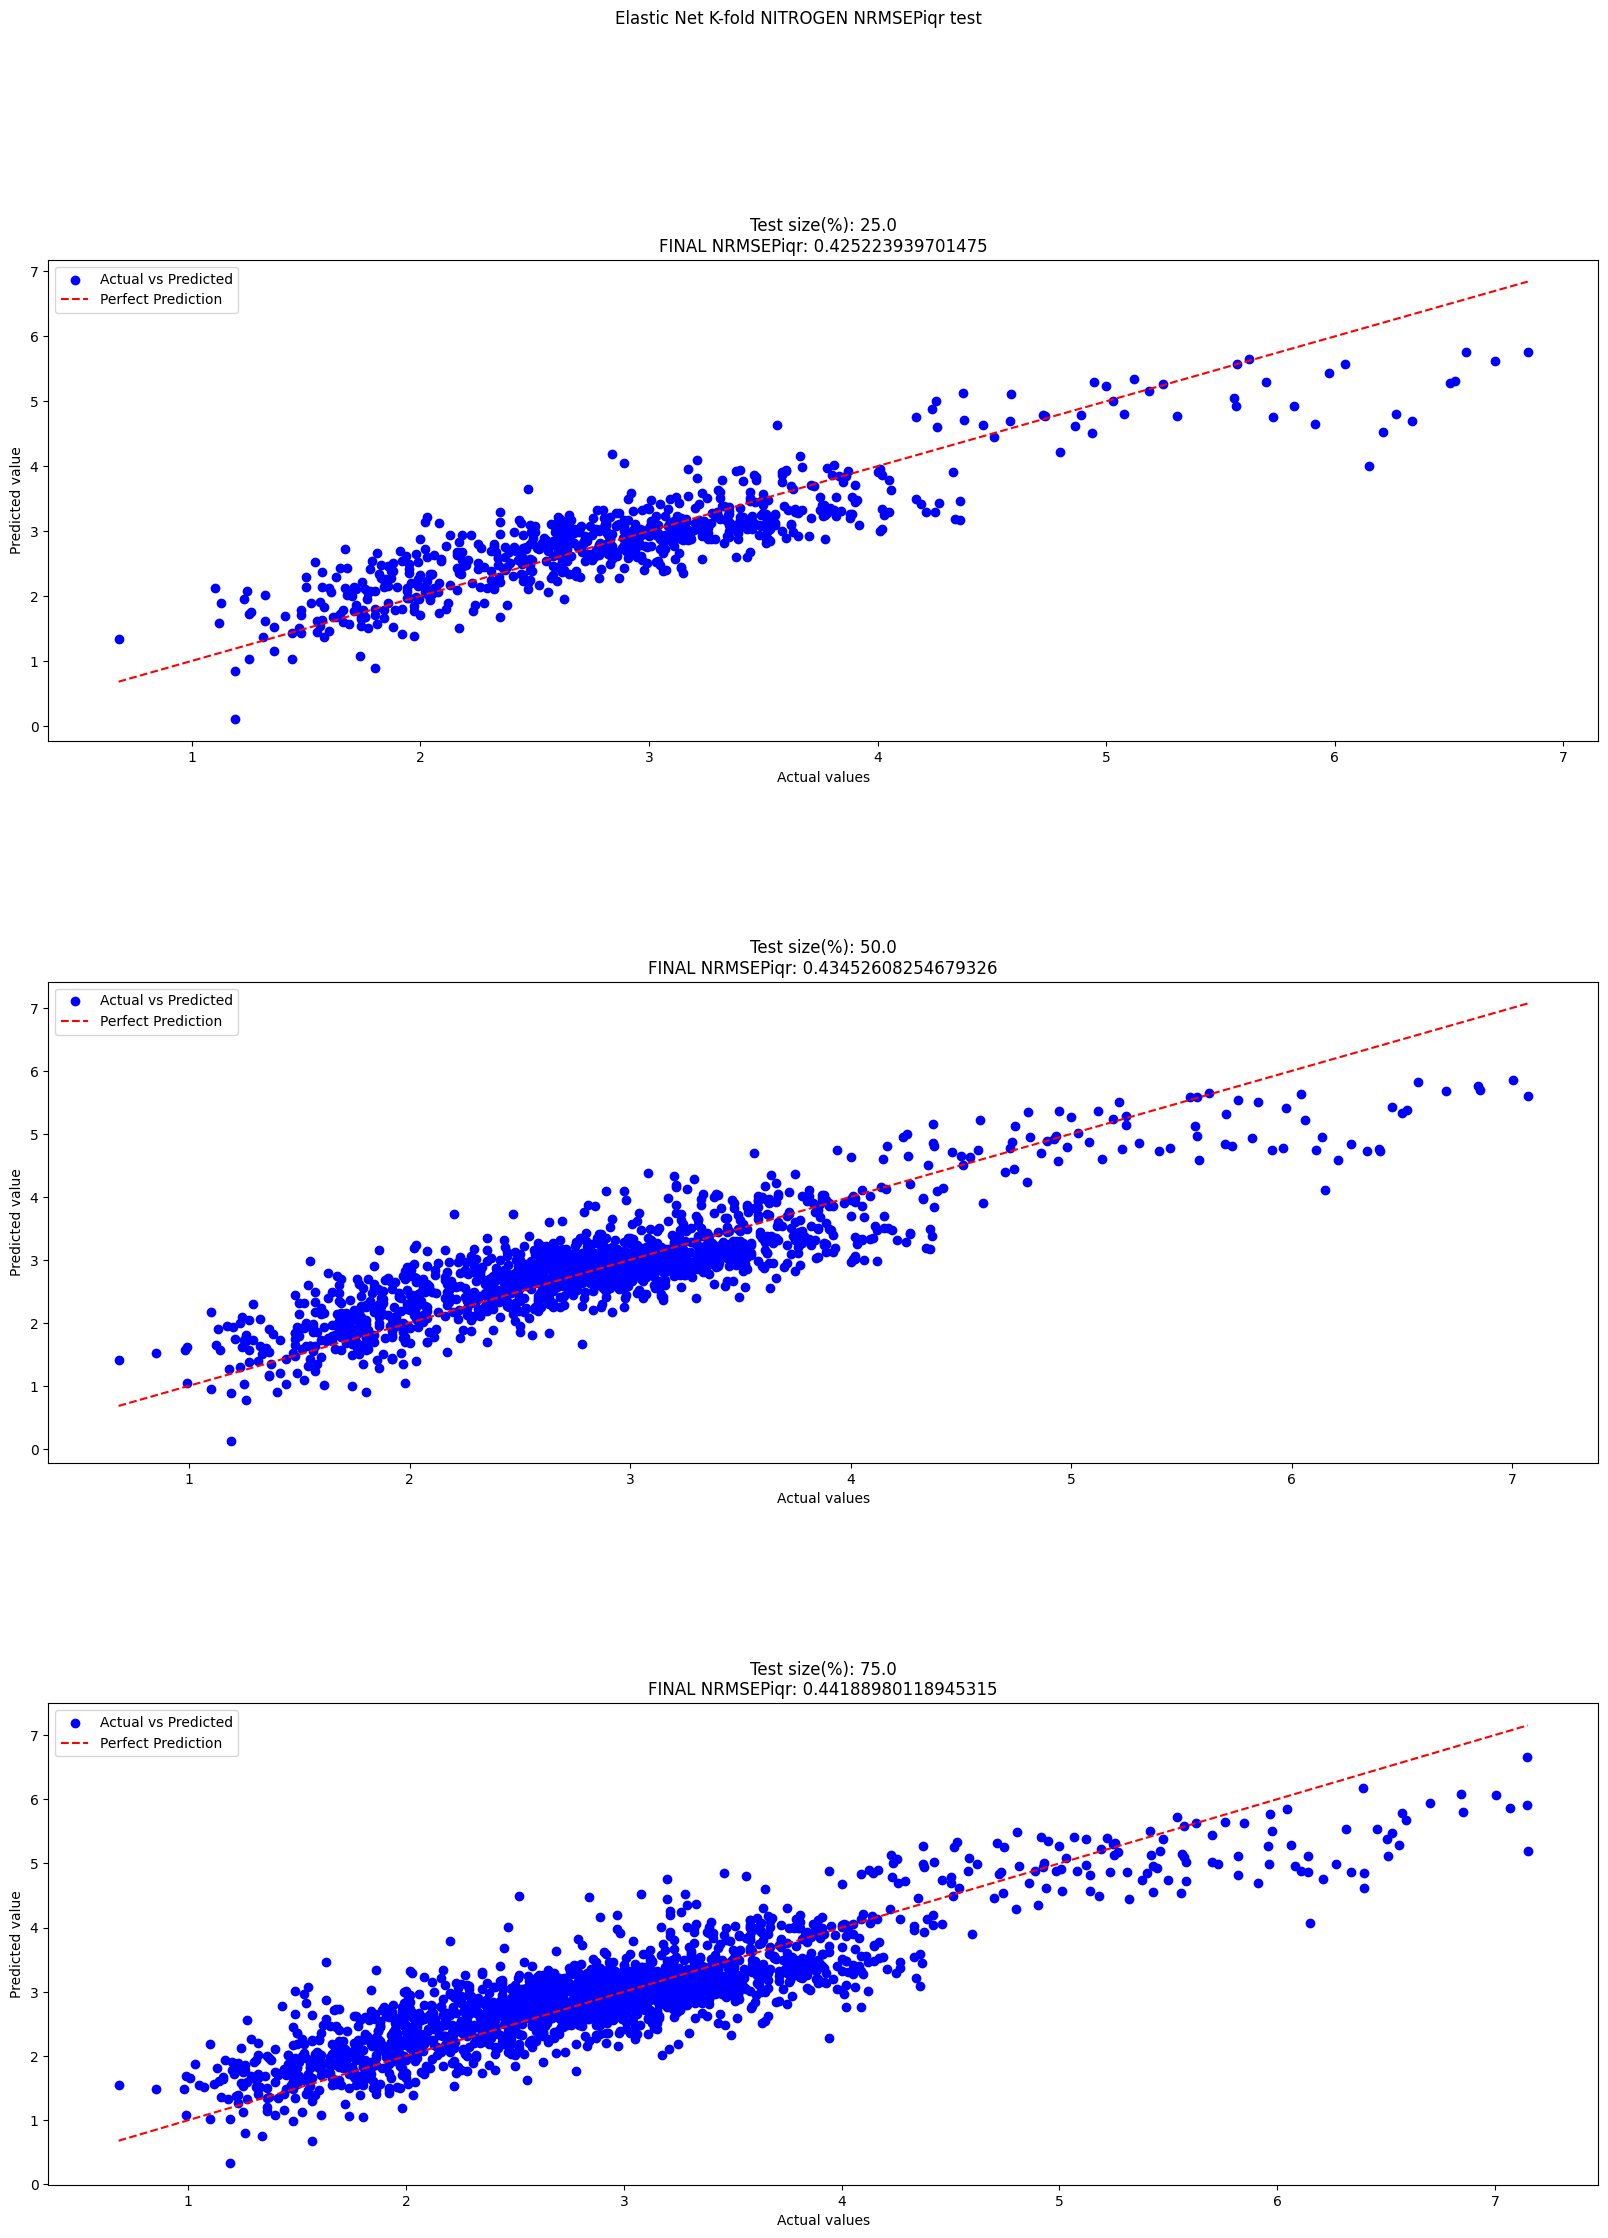

In [7]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Elastic Net K-fold NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'elasticnet__alpha': Continuous(1/100000,0.01),"elasticnet__l1_ratio":Continuous(0,1)}
    elastic_pipeline = make_pipeline(StandardScaler(),  ElasticNet())
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=elastic_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best value of alpha: ", str(evolved_estimator.best_params_["elasticnet__alpha"]))
    print("Best value of r: ", str(evolved_estimator.best_params_["elasticnet__l1_ratio"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_elastic = best_model.predict(X_test)

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_elastic),float(evolved_estimator.best_params_["elasticnet__alpha"]),float(evolved_estimator.best_params_["elasticnet__l1_ratio"])])

    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_elastic))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_elastic, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_elastic)))
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","alpha","r"]
print(tabulate(results, headers,  tablefmt="double_outline"))
